# Build a Neural Network with PyTorch

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
#!conda install pytorch -c pytorch -y
#!conda install helper -y
#print(torch.__version__)
#print(helper.view_classify)

## Get Dataset. 

This is provided through the torchvision package.

The code below will download the MNIST dataset, then create training and test datasets for us.

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into trainloader and we make that an iterator with iter(trainloader). We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that images is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

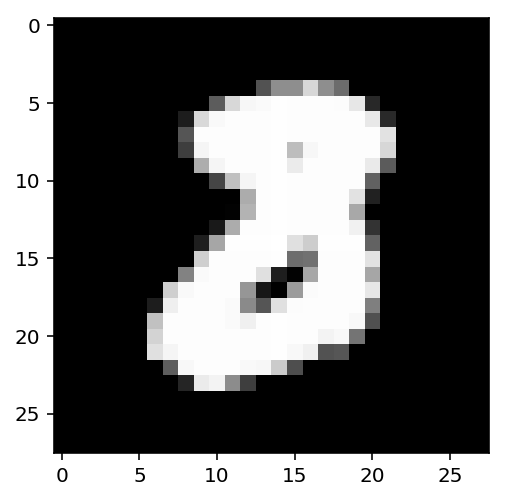

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.
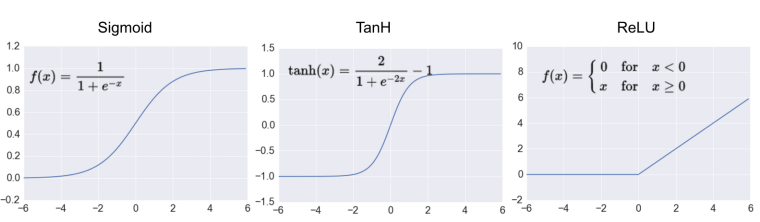

To build a neural network with PyTorch, you use the ```torch.nn``` module. The network itself is a class inheriting from ```torch.nn.Module```. You define each of the operations separately, like ```nn.Linear(784, 128)``` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a ```forward``` method that implements the forward pass through the network. In this method, you pass some input tensor x through each of the operations you defined earlier. The ```torch.nn``` module also has functional equivalents for things like ReLUs in ```torch.nn.functional```. This module is usually imported as ```F```. Then to use a ReLU activation on some layer (which is just a tensor), you'd do ```F.relu(x)```. Below are a few different commonly used activation functions.

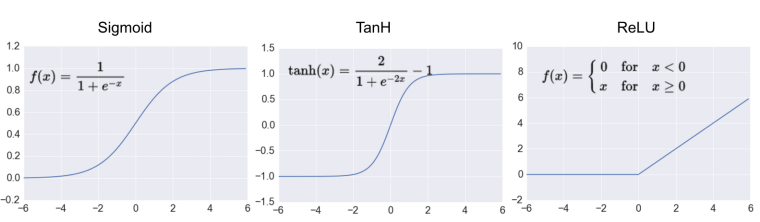

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [6]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Initializing weights and biases

The weights and such are automatically initialized, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the defined layer, you can get them with ```model.fc1.weight``` for instance.


In [ ]:
print(model.fc1.weight)
print(model.fc1.bias)

For custom initialization, we want to modify these tensors in place. These are actually autograd Variables, so we need to get back the actual tensors with model.fc1.weight.data. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.


In [8]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [9]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-1.5810e-02, -1.2891e-02, -1.6240e-02,  ..., -6.5761e-03,
          1.4901e-02,  4.6492e-03],
        [-1.4406e-02,  1.2279e-02, -4.2853e-03,  ...,  1.3191e-03,
         -5.4964e-03, -1.7940e-02],
        [ 1.2489e-02, -9.9809e-03, -4.6663e-03,  ...,  5.4562e-03,
         -1.5223e-02,  6.9782e-03],
        ...,
        [-1.2388e-02,  9.0968e-03,  1.6502e-02,  ..., -1.5744e-02,
          8.2121e-04,  4.1891e-03],
        [-6.8570e-03, -4.6140e-03, -3.9860e-03,  ...,  7.6926e-03,
         -3.4715e-03, -1.5442e-02],
        [-4.4312e-03, -4.0576e-03, -1.0644e-02,  ...,  4.7520e-03,
          3.7793e-03, -7.0619e-03]])

#### Forward Pass

Now that we have a network, let's see what happens when pass in an image. This is called the forward pass. 

During this step the image data gets converted into a tensor, then passes through all the operations defined by the network architecture.

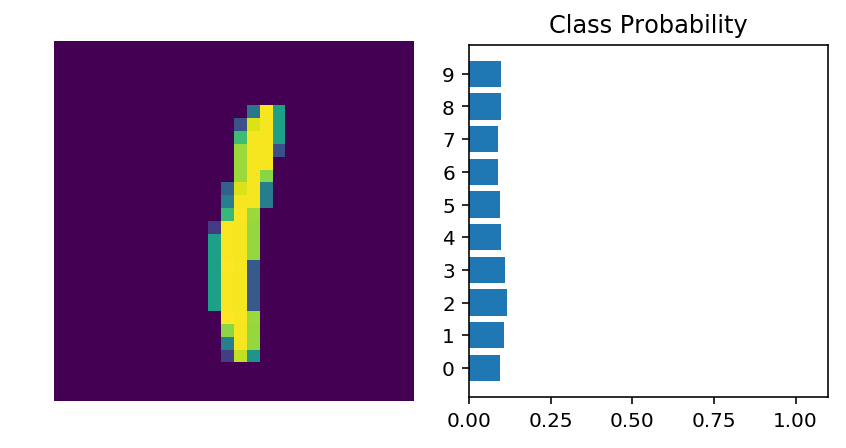

In [10]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)